## 3. LightGBM_FeatureSearch_black

Abstract:
- Feature search
- do not shuffle train data

## Run name

In [1]:
import time

project_name = 'AtecAntiFraud'
step_name = 'LightGBM_FeatureSearch_black'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515


## Important params

## Import PKGs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display
import seaborn as sns

import os
import sys
import gc
import math
import tqdm
import shutil
import zipfile
import pickle
import h5py
# import cv2
from PIL import Image

from tqdm import tqdm
import multiprocessing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

random_num = np.random.randint(10000)
cpu_amount = multiprocessing.cpu_count()

print('cpu_amount: %s' % (cpu_amount - 1))
print('random_num: %s' % random_num)

C:\Users\study\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cpu_amount: 3
random_num: 4308


In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

import xgboost
from xgboost import plot_importance

## Project folders

In [4]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
figure_folder = os.path.join(cwd, 'figure')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

test_a_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_a.csv')
test_b_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_b.csv')
train_csv_file = os.path.join(input_folder, 'atec_anti_fraud_train.csv')
sample_submission_csv_file = os.path.join(input_folder, 'demo.csv')

print(test_a_csv_file)
print(test_b_csv_file)
print(train_csv_file)
print(sample_submission_csv_file)

D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_a.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_b.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_train.csv
D:\bitbucket\atecantifraud\input\demo.csv


## Load data

In [5]:
dtypes = {
    'f1': 'float64',
    'f2': 'float64',
    'f3': 'float64',
    'f4': 'float64',
    'f5': 'float64', #int64
    'f6': 'float64',
    'f7': 'float64',
    'f8': 'float64',
    'f9': 'float64',
    'f10': 'float64',
    'f11': 'float64',
    'f12': 'float64',
    'f13': 'float64',
    'f14': 'float64',
    'f15': 'float64',
    'f16': 'float64',
    'f17': 'float64',
    'f18': 'float64',
    'f19': 'float64',
    'f20': 'float64',
}
# dtypes = None

In [6]:
%%time
# rows = 10000
rows = 30*10000

train_csv = pd.read_csv(train_csv_file, nrows=rows, dtype=dtypes, parse_dates=['date'])
test_a_csv = pd.read_csv(test_a_csv_file, nrows=None, dtype=dtypes, parse_dates=['date'])
sample_submission_csv = pd.read_csv(sample_submission_csv_file)

print(train_csv.shape)
print(test_a_csv.shape)
print(sample_submission_csv.shape)

display(train_csv.head())
display(test_a_csv.head())
display(sample_submission_csv.head())

(300000, 300)
(491668, 299)
(3, 2)


,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,f10eb20f31cf7063ee8bdbd1272214e4d7e0193c8dbce4...,0,2017-11-03,0.0,0.0,0.0,0.0,100807.0,0.0,5.0,...,301.0,312.0,328.0,85.0,302.0,201.0,203.0,203.0,61.0,201.0
1,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,0,2017-09-17,0.0,1.0,1.0,1.0,100805.0,1.0,5.0,...,302.0,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0
2,1270cb8a85eedd57672b2c6297fa5633e36773a2c3a351...,0,2017-10-22,0.0,0.0,1.0,0.0,100102.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,0,2017-10-29,0.0,0.0,0.0,1.0,100807.0,1.0,4.0,...,302.0,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0
4,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,0,2017-10-02,1.0,1.0,0.0,1.0,100805.0,1.0,5.0,...,302.0,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0


,id,date,f1,f2,f3,f4,f5,f6,f7,f8,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,2018-01-20,0.0,0.0,1.0,1.0,100809.0,1.0,3.0,2.0,...,302.0,302.0,302.0,134.0,302.0,215.0,215.0,215.0,94.0,214.0
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,2018-01-05,1.0,1.0,0.0,0.0,100808.0,1.0,5.0,2.0,...,39.0,40.0,40.0,39.0,40.0,39.0,39.0,39.0,39.0,39.0
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,2018-01-09,0.0,0.0,0.0,0.0,100803.0,0.0,6.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,2018-01-18,1.0,1.0,1.0,1.0,100808.0,0.0,3.0,2.0,...,301.0,301.0,302.0,122.0,301.0,208.0,208.0,207.0,89.0,207.0
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,2018-01-09,1.0,1.0,1.0,1.0,100809.0,0.0,2.0,2.0,...,301.0,302.0,302.0,118.0,302.0,251.0,251.0,251.0,101.0,251.0


,id,score
0,e43b0d4dc42f55bf5def4b6155856d9494fb7626d43bba...,0.000648
1,c17d52961284a02589e5bb684caa38868191fdb64d4711...,0.000203
2,dcf26d76f6d77651fc1e85d0be5dd835f0871cb72a9b03...,0.001065


Wall time: 27.8 s


## Train data and test data unoin

In [7]:
true_train_csv = train_csv[train_csv['label'] == 0]
false_train_csv = train_csv[train_csv['label'] == 1]
black_train_csv = train_csv[train_csv['label'] == -1]
# black_train_index = train_csv[train_csv['label'] == -1].index
# train_csv = train_csv[train_csv['label'] != -1]

print(true_train_csv.shape)
print(false_train_csv.shape)
print(true_train_csv.shape[0]/false_train_csv.shape[0])
print(black_train_csv.shape)
print(train_csv.shape)

(294875, 300)
(3665, 300)
80.45702592087312
(1460, 300)
(300000, 300)


In [8]:
display(train_csv.iloc[black_train_csv.index, :].head(5))
train_csv.iloc[black_train_csv.index, 1] = 1
display(train_csv.iloc[black_train_csv.index, :].head(5))

,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
73,140a310316038074cc92e9d9a38dfceafeaa63b4a2e0d4...,-1,2017-10-15,1.0,0.0,1.0,1.0,100806.0,1.0,4.0,...,301.0,309.0,309.0,80.0,301.0,187.0,188.0,188.0,59.0,187.0
195,e44de0fd7b7c050c8ecb20305c533c5c41e7faf52e9152...,-1,2017-10-07,0.0,1.0,1.0,0.0,100803.0,1.0,2.0,...,301.0,326.0,341.0,143.0,302.0,195.0,195.0,195.0,101.0,195.0
215,d5428698795e5fbce8caffadd0d25b097322e2d24dfa10...,-1,2017-10-17,1.0,0.0,0.0,0.0,100806.0,0.0,2.0,...,301.0,304.0,305.0,177.0,301.0,164.0,165.0,164.0,88.0,165.0
307,0927761e6c7a1e4619cfb9d2ec322285c5a4925fcb7c40...,-1,2017-10-05,0.0,0.0,0.0,1.0,100806.0,1.0,2.0,...,301.0,304.0,304.0,168.0,302.0,133.0,134.0,134.0,55.0,133.0
314,fbbe33dfcb1ffeb2ebf6f4c6cd6d2a3d85d84a07422c31...,-1,2017-09-26,0.0,1.0,1.0,1.0,100800.0,1.0,4.0,...,301.0,302.0,301.0,121.0,301.0,164.0,165.0,165.0,89.0,165.0


,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
73,140a310316038074cc92e9d9a38dfceafeaa63b4a2e0d4...,1,2017-10-15,1.0,0.0,1.0,1.0,100806.0,1.0,4.0,...,301.0,309.0,309.0,80.0,301.0,187.0,188.0,188.0,59.0,187.0
195,e44de0fd7b7c050c8ecb20305c533c5c41e7faf52e9152...,1,2017-10-07,0.0,1.0,1.0,0.0,100803.0,1.0,2.0,...,301.0,326.0,341.0,143.0,302.0,195.0,195.0,195.0,101.0,195.0
215,d5428698795e5fbce8caffadd0d25b097322e2d24dfa10...,1,2017-10-17,1.0,0.0,0.0,0.0,100806.0,0.0,2.0,...,301.0,304.0,305.0,177.0,301.0,164.0,165.0,164.0,88.0,165.0
307,0927761e6c7a1e4619cfb9d2ec322285c5a4925fcb7c40...,1,2017-10-05,0.0,0.0,0.0,1.0,100806.0,1.0,2.0,...,301.0,304.0,304.0,168.0,302.0,133.0,134.0,134.0,55.0,133.0
314,fbbe33dfcb1ffeb2ebf6f4c6cd6d2a3d85d84a07422c31...,1,2017-09-26,0.0,1.0,1.0,1.0,100800.0,1.0,4.0,...,301.0,302.0,301.0,121.0,301.0,164.0,165.0,165.0,89.0,165.0


In [9]:
id_data = train_csv['id']
id_test_a = test_a_csv['id']
train_csv = train_csv.drop(columns=['id'])
test_a_csv = test_a_csv.drop(columns=['id'])

y_data = train_csv['label']


train_csv = train_csv.drop(columns=['label'])

useless_features = []
x_data = train_csv.drop(columns=useless_features)
x_test_a = test_a_csv.drop(columns=useless_features)

print(train_csv.shape)
print(test_a_csv.shape)

print(id_data.shape)
print(id_test_a.shape)

print(y_data.shape)
print(x_data.shape)
print(x_test_a.shape)

(300000, 298)
(491668, 298)
(300000,)
(491668,)
(300000,)
(300000, 298)
(491668, 298)


In [10]:
len_x_data = len(x_data)
len_x_test_a = len(x_test_a)
print('len_x_data:\t', len_x_data)
print('len_x_test_a:\t', len_x_test_a)

data = pd.concat([x_data, x_test_a])

del train_csv
del test_a_csv
gc.collect()

len_x_data:	 300000
len_x_test_a:	 491668


127

## Data type and describe

In [11]:
## preview columns
cols = data.columns
print('col\tdata_type\tmin\tmax\tdata\t')
for col in cols:
    print(col, end='\t')
    print(data[col].dtype, end='\t\t')
    print(min(data[col]), end='\t')
    print(max(data[col]), end='\t')
    print(list(data[col][:20]))
    for d in list(data[col][:20]):
        if data[col].dtype == 'float64' and d>0. and d != int(d):
            print('*'*80)
            break

col	data_type	min	max	data	
date	datetime64[ns]		2017-09-05 00:00:00	2018-02-05 00:00:00	[Timestamp('2017-11-03 00:00:00'), Timestamp('2017-09-17 00:00:00'), Timestamp('2017-10-22 00:00:00'), Timestamp('2017-10-29 00:00:00'), Timestamp('2017-10-02 00:00:00'), Timestamp('2017-10-12 00:00:00'), Timestamp('2017-09-27 00:00:00'), Timestamp('2017-10-27 00:00:00'), Timestamp('2017-09-26 00:00:00'), Timestamp('2017-10-11 00:00:00'), Timestamp('2017-11-04 00:00:00'), Timestamp('2017-10-30 00:00:00'), Timestamp('2017-09-16 00:00:00'), Timestamp('2017-10-30 00:00:00'), Timestamp('2017-11-04 00:00:00'), Timestamp('2017-09-14 00:00:00'), Timestamp('2017-10-01 00:00:00'), Timestamp('2017-10-05 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2017-10-27 00:00:00')]
f1	float64		0.0	2.0	[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0]
f2	float64		0.0	2.0	[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0

f60	float64		1.0	3.0	[1.0, 1.0, nan, 2.0, 2.0, 1.0, nan, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 2.0, nan, 1.0, nan, 1.0, nan, nan]
f61	float64		1.0	9.0	[2.0, 4.0, nan, 3.0, 2.0, 2.0, nan, 2.0, 1.0, 5.0, 2.0, 1.0, 2.0, 2.0, nan, 4.0, nan, 2.0, nan, nan]
f62	float64		1.0	17.0	[2.0, 3.0, nan, 6.0, 1.0, 1.0, nan, 1.0, 1.0, 8.0, 2.0, 1.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f63	float64		1.0	32.0	[3.0, 3.0, nan, 6.0, 1.0, 2.0, nan, 2.0, 2.0, 17.0, 1.0, 2.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f64	float64		1.0	243.0	[96.0, 79.0, nan, nan, 89.0, 2.0, 201.0, nan, 1.0, 93.0, nan, 1.0, 2.0, nan, 1.0, 1.0, nan, 1.0, nan, nan]
f65	float64		1.0	59.0	[38.0, 12.0, nan, nan, 32.0, 2.0, 40.0, nan, 1.0, 36.0, nan, 2.0, 2.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f66	float64		1.0	430.0	[301.0, 302.0, nan, nan, 301.0, 18.0, 302.0, nan, 18.0, 302.0, nan, 2.0, 17.0, nan, 26.0, 1.0, nan, 6.0, nan, nan]
f67	float64		1.0	302.0	[302.0, 32.0, nan, nan, 243.0, 16.0, 302.0, nan, 1.0, 301.0, nan, 1.0, 1.0, nan, 4.0, 1.0,

f118	float64		1.0	251.0	[192.0, 122.0, nan, nan, 218.0, 2.0, 227.0, nan, 1.0, 193.0, nan, 2.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f119	float64		1.0	250.0	[191.0, 121.0, nan, nan, 217.0, 2.0, 227.0, nan, 1.0, 192.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f120	float64		1.0	249.0	[190.0, 16.0, nan, nan, 177.0, 2.0, 224.0, nan, 2.0, 190.0, nan, 1.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f121	float64		1.0	249.0	[190.0, 121.0, nan, nan, 216.0, 2.0, 224.0, nan, 1.0, 191.0, nan, 2.0, 2.0, nan, 1.0, 2.0, nan, 1.0, nan, nan]
f122	float64		1.0	249.0	[190.0, 122.0, nan, nan, 216.0, 1.0, 225.0, nan, 2.0, 191.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 1.0, nan, nan]
f123	float64		1.0	37.0	[32.0, 32.0, nan, nan, 35.0, 2.0, 34.0, nan, 1.0, 33.0, nan, 1.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f124	float64		1.0	37.0	[33.0, 31.0, nan, nan, 34.0, 1.0, 35.0, nan, 1.0, 35.0, nan, 2.0, 2.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f125	float64		1.0	33.0	[25.0, 13.0, nan, nan, 28.0, 1.0, 31.0, nan, 

f181	float64		1.0	11.0	[1.0, 1.0, 2.0, 3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0]
f182	float64		1.0	11.0	[2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0]
f183	float64		1.0	13.0	[4.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 4.0, 3.0, 1.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 1.0, 2.0]
f184	float64		1.0	16.0	[3.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 3.0, 2.0, 3.0, 3.0, 2.0, 5.0, 3.0, 2.0, 2.0, 3.0]
f185	float64		1.0	22.0	[4.0, 2.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 3.0, 4.0, 3.0, 2.0, 2.0, 5.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0]
f186	float64		1.0	4.0	[2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0]
f187	float64		1.0	5.0	[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
f188	float64		1.0	7.0	[1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0]
f189	float6

f245	float64		1.0	302.0	[5.0, 2.0, 2.0, 1.0, 2.0, 7.0, 8.0, 1.0, 1.0, 2.0, 94.0, 2.0, 2.0, 2.0, 3.0, 8.0, 154.0, 2.0, 2.0, 302.0]
f246	float64		1.0	302.0	[5.0, 1.0, 2.0, 1.0, 2.0, 8.0, 8.0, 2.0, 1.0, 1.0, 94.0, 1.0, 2.0, 1.0, 4.0, 28.0, 302.0, 3.0, 2.0, 302.0]
f247	float64		1.0	305.0	[10.0, 2.0, 7.0, 1.0, 3.0, 8.0, 8.0, 5.0, 1.0, 2.0, 94.0, 2.0, 9.0, 2.0, 4.0, 115.0, 301.0, 2.0, 1.0, 302.0]
f248	float64		1.0	463.0	[16.0, 2.0, 13.0, 2.0, 3.0, 7.0, 8.0, 7.0, 1.0, 1.0, 94.0, 2.0, 9.0, 2.0, 4.0, 143.0, 301.0, 2.0, 2.0, 301.0]
f249	float64		1.0	206.0	[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 5.0, 70.0, 2.0, 2.0, 82.0]
f250	float64		1.0	291.0	[2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 8.0, 127.0, 1.0, 2.0, 242.0]
f251	float64		1.0	291.0	[4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 22.0, 235.0, 2.0, 1.0, 242.0]
f252	float64		1.0	291.0	[5.0, 1.0, 4.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2

In [12]:
# train_max = train_csv.max()
# print(train_max.shape)
# display(train_max)

## Filter

## Feature engine

## Feature generate

In [13]:
## date
def do_date(df):
#     df['year'] = df['date'].dt.year.astype('uint16')
    df['month'] = df['date'].dt.month.astype('uint8')
    df['day'] = df['date'].dt.day.astype('uint8')
    df['weekday'] = df['date'].dt.weekday.astype('uint8')
    return df

data = do_date(data)
data = data.drop(columns=['date'])

pass

In [14]:
def do_plus(df, feature_couple, use_cols=None):
    new_feature_name = 'gd_' + '_d_'.join(feature_couple)
    if use_cols is not None and new_feature_name not in use_cols:
        print(new_feature_name, end=' ')
        return df
    df[new_feature_name] = df[feature_couple[0]] + df[feature_couple[1]]
#     display(df[new_feature_name].head())

# do_plus(data, ('f1', 'f2'))

In [15]:
def do_multiply(df, feature_couple, use_cols=None):
    new_feature_name = 'gm_' + '_m_'.join(feature_couple)
    if use_cols is not None and new_feature_name not in use_cols:
        print(new_feature_name, end=' ')
        return df
    df[new_feature_name] = (df[feature_couple[0]]+0.1) * (df[feature_couple[1]]+0.1)
#     display(df[new_feature_name].head())

# do_multiply(data, ('f1', 'f2'))

In [16]:
feature_couples = []
data_cols = list(data.columns)
print(data_cols)
# want to robust to remove id nad lable, so use try
try:
    data_cols.remove('id')
    data_cols.remove('label')
except Exception as ex:
    print(ex)
print(data_cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f1

In [17]:
%%time
len_data_cols = len(data_cols)
len_data_cols = 20
for i in range(len_data_cols - 1):
    for j in range(i+1, len_data_cols):
        if i == j:
            print('-', end='')
            continue
        if (data_cols[i], data_cols[j]) in feature_couples:
            print('+', end='')
            continue
        feature_couples.append((data_cols[i], data_cols[j]))
print(len(feature_couples))

190
Wall time: 4.03 ms


In [18]:
print(feature_couples[:20])

[('f1', 'f2'), ('f1', 'f3'), ('f1', 'f4'), ('f1', 'f5'), ('f1', 'f6'), ('f1', 'f7'), ('f1', 'f8'), ('f1', 'f9'), ('f1', 'f10'), ('f1', 'f11'), ('f1', 'f12'), ('f1', 'f13'), ('f1', 'f14'), ('f1', 'f15'), ('f1', 'f16'), ('f1', 'f17'), ('f1', 'f18'), ('f1', 'f19'), ('f1', 'f20'), ('f2', 'f3')]


In [19]:
use_cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17']
use_cols = None

for f_couple in feature_couples:
    print(f_couple)
    do_plus(data, f_couple, use_cols)
    do_multiply(data, f_couple, use_cols)

('f1', 'f2')
('f1', 'f3')
('f1', 'f4')
('f1', 'f5')
('f1', 'f6')
('f1', 'f7')
('f1', 'f8')
('f1', 'f9')
('f1', 'f10')
('f1', 'f11')
('f1', 'f12')
('f1', 'f13')
('f1', 'f14')
('f1', 'f15')
('f1', 'f16')
('f1', 'f17')
('f1', 'f18')
('f1', 'f19')
('f1', 'f20')
('f2', 'f3')
('f2', 'f4')
('f2', 'f5')
('f2', 'f6')
('f2', 'f7')
('f2', 'f8')
('f2', 'f9')
('f2', 'f10')
('f2', 'f11')
('f2', 'f12')
('f2', 'f13')
('f2', 'f14')
('f2', 'f15')
('f2', 'f16')
('f2', 'f17')
('f2', 'f18')
('f2', 'f19')
('f2', 'f20')
('f3', 'f4')
('f3', 'f5')
('f3', 'f6')
('f3', 'f7')
('f3', 'f8')
('f3', 'f9')
('f3', 'f10')
('f3', 'f11')
('f3', 'f12')
('f3', 'f13')
('f3', 'f14')
('f3', 'f15')
('f3', 'f16')
('f3', 'f17')
('f3', 'f18')
('f3', 'f19')
('f3', 'f20')
('f4', 'f5')
('f4', 'f6')
('f4', 'f7')
('f4', 'f8')
('f4', 'f9')
('f4', 'f10')
('f4', 'f11')
('f4', 'f12')
('f4', 'f13')
('f4', 'f14')
('f4', 'f15')
('f4', 'f16')
('f4', 'f17')
('f4', 'f18')
('f4', 'f19')
('f4', 'f20')
('f5', 'f6')
('f5', 'f7')
('f5', 'f8')
('f5', 

In [20]:
%%time
# use_cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17']

# cols = data.columns
# for col in cols:
#     if col not in use_cols:
#         print(col, end=' ')
#         data = data.drop(columns=[col])
#         gc.collect()

Wall time: 0 ns


In [21]:
print(data.shape)
print(data.columns)

(791668, 680)
Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'gd_f17_d_f19', 'gm_f17_m_f19', 'gd_f17_d_f20', 'gm_f17_m_f20',
       'gd_f18_d_f19', 'gm_f18_m_f19', 'gd_f18_d_f20', 'gm_f18_m_f20',
       'gd_f19_d_f20', 'gm_f19_m_f20'],
      dtype='object', length=680)


In [22]:
## preview columns again
cols = data.columns
print('col\tdata_type\tmax\tdata\t')
for col in cols[-10:]:
    print(col, end='\t')
    print(data[col].dtype, end='\t\t')
    print(max(data[col]), end='\t')
    print(list(data[col][:10]))

col	data_type	max	data	
gd_f17_d_f19	float64		4.0	[3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 4.0, 2.0, 2.0, 2.0]
gm_f17_m_f19	float64		4.41	[2.3100000000000005, 0.11000000000000001, 2.3100000000000005, 1.2100000000000002, 0.11000000000000001, 2.3100000000000005, 4.41, 0.21000000000000002, 1.2100000000000002, 1.2100000000000002]
gd_f17_d_f20	float64		34.0	[33.0, 15.0, nan, 33.0, 29.0, 2.0, 26.0, 33.0, 1.0, 33.0]
gm_f17_m_f20	float64		67.41000000000001	[65.31, 15.510000000000002, nan, 35.31, 30.910000000000004, 0.21000000000000002, 50.61000000000001, 65.31, 0.11000000000000001, 35.31]
gd_f18_d_f19	float64		4.0	[3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 3.0]
gm_f18_m_f19	float64		4.41	[2.3100000000000005, 0.21000000000000002, 1.2100000000000002, 1.2100000000000002, 0.21000000000000002, 1.2100000000000002, 4.41, 0.21000000000000002, 2.3100000000000005, 2.3100000000000005]
gd_f18_d_f20	float64		34.0	[33.0, 16.0, nan, 33.0, 30.0, 1.0, 26.0, 33.0, 2.0, 34.0]
gm_f18_m_f20	float64		67.41000000000001	[65

## Prepare x_data

In [23]:
x_data = data[:len_x_data]
x_test_a = data[len_x_data:]
print(x_data.shape)
print(x_test_a.shape)

print(list(x_data.columns))
print(list(x_data.dtypes))

(300000, 680)
(491668, 680)
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135',

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('fl

## Split data

In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=random_num, shuffle=False)

# x_train, y_train = shuffle(x_train, y_train, random_state=random_num)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(270000, 680)
(270000,)
(30000, 680)
(30000,)


## Train

In [25]:
%%time
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# lgb_train = lgb.Dataset(x_train, label=y_train)
# lgb_val = lgb.Dataset(x_val, label=y_val, reference=lgb_train)

colsample = 30.
colsample_bytree = round(colsample/len(x_train.columns), 4)
print('colsample_bytree: %.5f' % colsample_bytree)

# LightGBM parameters
param_grid = {
#     'task': 'train',
#     'num_boost_round': [200],
#     'early_stopping_rounds': [10],
#     'boosting_type': ['gbdt'], # (default="gbdt")
#     'num_leaves': [300], # (default=31)
#     'max_depth': [10, 8, 6], # (default=-1)
#     'learning_rate': [0.1], # (default=0.1)
#     'n_estimators': [2000, 500], # (default=10)
#     'max_bin': [1000, 255], # (default=255)
#     'subsample_for_bin': [100*10000], # (default=50000)
#     'objective': ['binary'], # (default=None)
#     'min_split_gain': [0.], # (default=0.)
#     'min_child_weight': [1e-3], # (default=1e-3)
#     'min_child_samples': [10], # (default=20)
#     'subsample': [0.7], # (default=1.)
#     'subsample_freq': [1], # (default=1)
#     'colsample_bytree': [0.9], # (default=1.)
#     'reg_alpha': [0., 0.3], # (default=0.)
#     'reg_lambda': [0., 0.3], # (default=0.)
#     'random_state': [random_num], # (default=None)
#     'n_jobs': [-1], # (default=-1)
#     'silent': [False], # (default=True)
#     'metric': ['auc', 'binary_logloss'],
}
# print('params: ', params)
# train
clf = lgb.LGBMClassifier(
#     'num_boost_round'=200,
#     'early_stopping_rounds'=10,
    boosting_type='gbdt', # (default="gbdt")
    num_leaves=512, # (default=31)
    max_depth=8, # (default=-1)
    learning_rate=0.1, # (default=0.1)
    n_estimators=500, # (default=10)
#     max_bin=255, # (default=255)
    subsample_for_bin=500, # (default=50000)
    objective='binary', # (default=None)
    class_weight=None,
    min_split_gain=0., # (default=0.)
    min_child_weight=1e-3, # (default=1e-3)
    min_child_samples=20, # (default=20)
    subsample=0.5, # (default=1.)
#     subsample_freq=1, # (default=1)
    colsample_bytree=colsample_bytree, # (default=1.)
    reg_alpha=0., # (default=0.)
    reg_lambda=0.3, # (default=0.)
    random_state=random_num, # (default=None)
    n_jobs=-1, # (default=-1)
    silent=False, # (default=True)
#     'metric'=['auc', 'binary_logloss'],
)
# gbm = lgb.train(
#     params,
#     train_set=lgb_train,
#     valid_sets=lgb_val
# )
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2, cv=3, n_jobs=1, scoring='roc_auc')
grid_search.fit(x_train, y_train)

colsample_bytree: 0.04410
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ................................................. , total= 3.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total= 3.0min
[CV]  ................................................................
[CV] ................................................. , total= 2.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.4min finished


Wall time: 13min 16s


In [26]:
%%time

print('*' * 80)
y_train_proba = grid_search.predict_proba(x_train)
print(y_train.shape)
print(y_train_proba.shape)
print(y_train_proba[:10])
y_train_pred = (y_train_proba[:, 1]>=0.5).astype(int)
acc_train = accuracy_score(y_train, y_train_pred)
roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

# y_train_pred = grid_search.predict(x_train)
# acc_train = accuracy_score(y_train, y_train_pred)
# roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
# print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

y_val_proba = grid_search.predict_proba(x_val)
print(y_val.shape)
print(y_val_proba.shape)
print(y_val_proba[:10])
y_val_pred = (y_val_proba[:, 1]>=0.5).astype(int)
print(y_val.shape)
print(y_val_pred.shape)
acc_val = accuracy_score(y_val, y_val_pred)
roc_val = roc_auc_score(y_val, y_val_proba[:, 1])
print('acc_val:   %.4f \t roc_val:   %.4f' % (acc_val, roc_val))

********************************************************************************
(270000,)
(270000, 2)
[[9.99987413e-01 1.25870110e-05]
 [9.99966862e-01 3.31378243e-05]
 [9.99967670e-01 3.23304481e-05]
 [9.99050751e-01 9.49248846e-04]
 [9.99654133e-01 3.45866880e-04]
 [9.99836249e-01 1.63750896e-04]
 [9.99995562e-01 4.43813357e-06]
 [9.99999159e-01 8.40526114e-07]
 [9.99996589e-01 3.41059773e-06]
 [9.99996899e-01 3.10117630e-06]]
acc_train: 0.9998 	 roc_train: 1.0000
(30000,)
(30000, 2)
[[9.99945196e-01 5.48044091e-05]
 [9.98333289e-01 1.66671070e-03]
 [9.99989645e-01 1.03547115e-05]
 [9.99992934e-01 7.06642612e-06]
 [9.99996518e-01 3.48236794e-06]
 [9.99997937e-01 2.06303324e-06]
 [9.99958431e-01 4.15694301e-05]
 [9.99940742e-01 5.92575192e-05]
 [9.81774767e-01 1.82252331e-02]
 [9.99969596e-01 3.04039191e-05]]
(30000,)
(30000,)
acc_val:   0.9862 	 roc_val:   0.9819
Wall time: 20.5 s


In [27]:
print(grid_search.cv_results_)
print('*' * 60)
print(grid_search.grid_scores_ )
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.scorer_)
print('*' * 60)
print(type(grid_search.best_estimator_))
print(dir(grid_search.best_estimator_))

{'mean_fit_time': array([167.78309512]), 'std_fit_time': array([5.38122977]), 'mean_score_time': array([6.33301504]), 'std_score_time': array([0.63943681]), 'params': [{}], 'split0_test_score': array([0.97768785]), 'split1_test_score': array([0.97828115]), 'split2_test_score': array([0.9754692]), 'mean_test_score': array([0.97714608]), 'std_test_score': array([0.00121021]), 'rank_test_score': array([1]), 'split0_train_score': array([0.99999883]), 'split1_train_score': array([0.99999825]), 'split2_train_score': array([0.99999274]), 'mean_train_score': array([0.99999661]), 'std_train_score': array([2.74185735e-06])}
************************************************************
[mean: 0.97715, std: 0.00121, params: {}]
LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.0441, learning_rate=0.1, max_depth=8,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=512, objective='binary',
       

In [28]:
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,167.783095,6.333015,0.977146,0.999997,{},1,0.977688,0.999999,0.978281,0.999998,0.975469,0.999993,5.38123,0.639437,0.00121,0.000003


In [29]:
fe_times = grid_search.best_estimator_.booster_.feature_importance()
fe_name = grid_search.best_estimator_.booster_.feature_name()
print(fe_times)
print(fe_name)

[ 37  32  30  43  70  82 128  40  71  63  65  55  69  28  39  42  70  62
  69  58 111 101 160  52  31  62  42  41  63  57  44  71 132 110 160   7
   6   3  14  10  11  12   9  12  11   6   7 172 125 130  96  31  60 146
 124 159 147  99  33  63  69  48  82 143 107  92 103  74  77  75  89 151
 195 171 143 106 103 128 173 124 293 246 194 175 238 219  30  39  63  61
  77  26  26  35  32  32  45  92  97 111 117 120 133 210 167 242 168 157
 186 135  65 134  84 101 110  81 133  89 100  35  81  51  39  79  58  72
  84  83  49  56 104  79  98 175  51  50  65  35  56  82  44 118 115 128
 115 120 125 112  92  84  81  52  83  44  29  23  21  31  21  30  81 154
 104 231 100  29  26  28  28  31  33  48  50  59  87  51  85  43  35  56
  67  45  72 111  60  49  35  28  28  26  55  58  67  22  35  26  31  44
  15  30  18  22  33 103 181 220 188 214 167 285 110  67 131 143 161 255
 191 238  57 123  93 177 117 123  86 107  91 120 167 107  68 137  92 281
 292 192 248 255 123 122 122 113 151 405 230 173 31

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f1

,feature,importance
0,f1,37
1,f2,32
2,f3,30
3,f4,43
4,f5,70


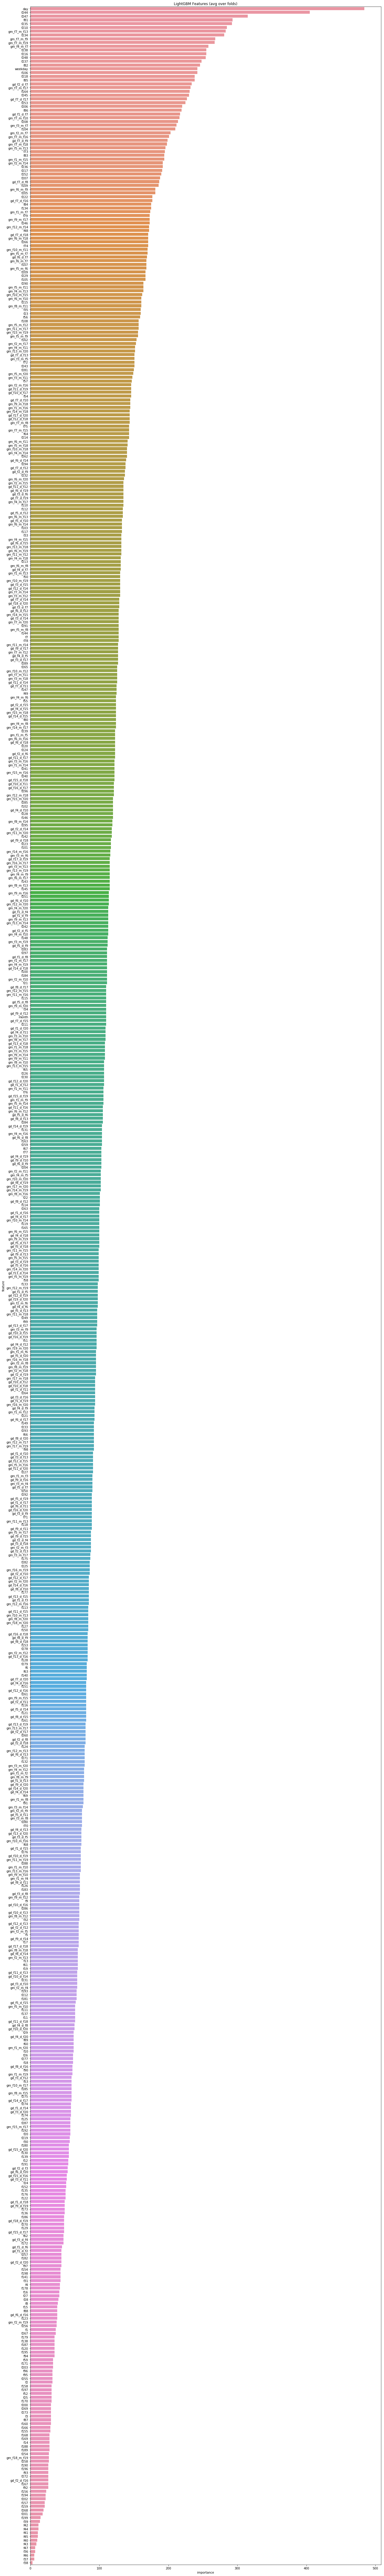

In [30]:
importance_score = pd.DataFrame(data={'feature': fe_name, 'importance': fe_times})
display(importance_score.head())

plt.figure(figsize=(18,120))
# sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
sns.barplot(x="importance", y="feature", data=importance_score.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [31]:
importance_score=importance_score.sort_values(by='importance', ascending=False)
importance_csv_file = os.path.join(log_folder, 'importance_%s.csv' % run_name)
print(importance_csv_file)
importance_score.to_csv(importance_csv_file, index = True)

display(importance_score['feature'][:5])
for i, item in enumerate(importance_score.values):
    print('%s\t%s\t%s' % (i, item[1], item[0]))

D:\bitbucket\atecantifraud\log\importance_AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515.csv


298     day
243    f244
246    f247
80      f81
234    f235
Name: feature, dtype: object

0	484	day
1	405	f244
2	315	f247
3	293	f81
4	292	f235
5	285	f210
6	283	gm_f7_m_f13
7	281	f234
8	268	gm_f7_m_f9
9	267	gm_f7_m_f19
10	258	gm_f4_m_f7
11	255	f238
12	255	f216
13	254	f248
14	248	f237
15	246	f82
16	242	weekday
17	242	f106
18	238	f218
19	238	f85
20	234	gd_f2_d_f7
21	232	gm_f7_m_f17
22	231	f164
23	230	f245
24	227	gd_f7_d_f17
25	225	f253
26	220	f206
27	219	f86
28	217	gd_f1_d_f7
29	216	gm_f7_m_f10
30	214	f208
31	212	gm_f3_m_f7
32	210	f104
33	203	gm_f2_m_f7
34	201	gm_f7_m_f16
35	199	gd_f7_d_f9
36	198	gm_f7_m_f18
37	196	gm_f5_m_f13
38	195	f73
39	194	f83
40	194	gm_f1_m_f15
41	192	gm_f2_m_f14
42	192	f236
43	191	f217
44	190	f252
45	188	f207
46	187	gd_f7_d_f8
47	186	f109
48	181	gm_f6_m_f9
49	181	f205
50	177	f222
51	177	gd_f7_d_f16
52	175	f84
53	175	f134
54	174	gm_f1_m_f7
55	173	f79
56	173	gm_f9_m_f17
57	173	f246
58	172	gm_f12_m_f14
59	172	f48
60	171	gd_f7_d_f18
61	171	gm_f6_m_f18
62	171	f266
63	171	f74
64	170	gm_f10_m_f11
65	170	gm_f5_m_f7
66	169	gd_f6_d_f7
67	168	gm_f6_m_f7
68	168	f10

480	75	gd_f5_d_f11
481	75	gm_f3_m_f8
482	75	f280
483	75	f70
484	74	gd_f4_d_f13
485	74	gd_f13_d_f20
486	74	gd_f3_d_f5
487	74	gm_f10_m_f16
488	74	f68
489	73	gd_f1_d_f15
490	73	f276
491	73	gd_f10_d_f19
492	73	gm_f11_m_f19
493	73	f288
494	73	gm_f1_m_f10
495	73	gm_f13_m_f16
496	72	gm_f9_m_f10
497	72	gm_f1_m_f4
498	72	gd_f8_d_f11
499	72	f126
500	72	f183
501	72	gd_f3_d_f8
502	71	gm_f9_m_f12
503	71	f9
504	71	gd_f10_d_f16
505	71	f286
506	71	gd_f10_d_f13
507	71	gm_f8_m_f12
508	71	f32
509	70	gd_f12_d_f13
510	70	gd_f2_d_f12
511	70	gm_f2_m_f5
512	70	f5
513	70	gd_f9_d_f14
514	70	f17
515	70	gd_f17_d_f18
516	69	gm_f8_m_f18
517	69	gd_f8_d_f14
518	69	gm_f2_m_f13
519	69	f13
520	69	f61
521	69	f19
522	68	gd_f11_d_f13
523	68	gd_f10_d_f14
524	68	f231
525	68	gd_f3_d_f10
526	68	gm_f2_m_f4
527	67	f193
528	67	f212
529	67	f181
530	66	gd_f5_d_f15
531	65	gm_f5_m_f10
532	65	f111
533	65	f137
534	65	f11
535	65	gd_f11_d_f18
536	64	gd_f4_d_f8
537	64	gd_f10_d_f20
538	63	f29
539	63	gd_f4_d_f20
540	63	f89
541	63	f60
542	63

In [32]:
print('[', end='')
for i, f in enumerate(importance_score.values):
    print('\'%s\'' % f[0], end='')
    if i<50:
        print(', ', end='')
    else:
        print('', end='')
        break
print(']')

['day', 'f244', 'f247', 'f81', 'f235', 'f210', 'gm_f7_m_f13', 'f234', 'gm_f7_m_f9', 'gm_f7_m_f19', 'gm_f4_m_f7', 'f238', 'f216', 'f248', 'f237', 'f82', 'weekday', 'f106', 'f218', 'f85', 'gd_f2_d_f7', 'gm_f7_m_f17', 'f164', 'f245', 'gd_f7_d_f17', 'f253', 'f206', 'f86', 'gd_f1_d_f7', 'gm_f7_m_f10', 'f208', 'gm_f3_m_f7', 'f104', 'gm_f2_m_f7', 'gm_f7_m_f16', 'gd_f7_d_f9', 'gm_f7_m_f18', 'gm_f5_m_f13', 'f73', 'f83', 'gm_f1_m_f15', 'gm_f2_m_f14', 'f236', 'f217', 'f252', 'f207', 'gd_f7_d_f8', 'f109', 'gm_f6_m_f9', 'f205', 'f222']


In [33]:
# cols = ['day', 'f237', 'f244', 'weekday', 'f246', 'f248', 'f215', 'f236', 'f234', 'f218', 'gm_f3_m_f19', 'f235', 'f245', 'f238', 'gm_f6_m_f7', 'f217', 'f216', 'f253', 'f247', 'gm_f6_m_f18', 'f252', 'gm_f7_m_f19', 'gm_f7_m_f14', 'gm_f14_m_f17', 'gm_f7_m_f15', 'gm_f11_m_f14', 'gm_f6_m_f19', 'gm_f6_m_f15', 'f82', 'gm_f7_m_f17', 'gm_f7_m_f10', 'gm_f4_m_f7', 'gm_f7_m_f12', 'gm_f7_m_f13', 'gm_f14_m_f15', 'gd_f7_d_f19', 'f210', 'gm_f7_m_f16', 'gm_f7_m_f9', 'gm_f1_m_f7', 'gd_f7_d_f17', 'gd_f7_d_f18', 'gm_f6_m_f16', 'gm_f3_m_f7', 'gm_f1_m_f16', 'gd_f6_d_f7', 'f243', 'gd_f7_d_f14', 'gm_f18_m_f19', 'gd_f1_d_f7', 'f86']


## Predict

In [34]:
run_name_acc = run_name + '_' + str(int(roc_val*10000)).zfill(4)
print(run_name_acc)

AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515_9819


In [35]:
y_test_a_proba = grid_search.predict_proba(x_test_a)

print(y_test_a_proba.shape)
print(y_test_a_proba[:10])

y_test_a_proba_true = y_test_a_proba[:, 1]

print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

(491668, 2)
[[9.99932500e-01 6.75000095e-05]
 [9.99267848e-01 7.32151503e-04]
 [9.99997359e-01 2.64053099e-06]
 [9.99411343e-01 5.88657178e-04]
 [9.98379039e-01 1.62096146e-03]
 [9.99623790e-01 3.76209628e-04]
 [9.99725879e-01 2.74121299e-04]
 [9.99990124e-01 9.87616930e-06]
 [9.99382339e-01 6.17661264e-04]
 [9.96264382e-01 3.73561827e-03]]
(491668,)
[6.75000095e-05 7.32151503e-04 2.64053099e-06 5.88657178e-04
 1.62096146e-03 3.76209628e-04 2.74121299e-04 9.87616930e-06
 6.17661264e-04 3.73561827e-03]


In [36]:
y_data_proba = grid_search.predict_proba(x_data)

print(y_data_proba.shape)
print(y_data_proba[:10])

y_data_proba_true = y_data_proba[:, 1]

print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

(300000, 2)
[[9.99987413e-01 1.25870110e-05]
 [9.99966862e-01 3.31378243e-05]
 [9.99967670e-01 3.23304481e-05]
 [9.99050751e-01 9.49248846e-04]
 [9.99654133e-01 3.45866880e-04]
 [9.99836249e-01 1.63750896e-04]
 [9.99995562e-01 4.43813357e-06]
 [9.99999159e-01 8.40526114e-07]
 [9.99996589e-01 3.41059773e-06]
 [9.99996899e-01 3.10117630e-06]]
(300000,)
[1.25870110e-05 3.31378243e-05 3.23304481e-05 9.49248846e-04
 3.45866880e-04 1.63750896e-04 4.43813357e-06 8.40526114e-07
 3.41059773e-06 3.10117630e-06]


In [37]:
def save_proba(y_data_proba, y_data, y_test_a_proba, id_test_a, file_name):
    id_test_a = [id_str.encode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: %s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_data_proba', data=y_data_proba)
        h.create_dataset('y_data', data=y_data)
        h.create_dataset('y_test_a_proba', data=y_test_a_proba)
        h.create_dataset('id_test_a', data=id_test_a)
    print('File saved:   %s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_data_proba = np.array(h['y_data_proba'])
        y_data = np.array(h['y_data'])
        y_test_a_proba = np.array(h['y_test_a_proba'])
        id_test_a = np.array(h['id_test_a'])
    print('File loaded:  %s' % file_name)
    id_test_a = [id_str.decode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    
    return y_data_proba, y_data, y_test_a_proba, id_test_a


y_proba_file = os.path.join(model_folder, 'proba_a_%s.p' % run_name_acc)
save_proba(
    y_data_proba, 
    y_data, 
    y_test_a_proba, 
    list(id_test_a),
    y_proba_file
)
y_data_proba, y_data, y_test_a_proba, id_test_a = load_proba(y_proba_file)

print('*'*80)
print(y_data_proba.shape)
print(y_data_proba[:10])
y_data_proba_true = y_data_proba[:, 1]
print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

print('*'*80)
print(y_test_a_proba.shape)
print(y_test_a_proba[:10])
print(len(id_test_a))
y_test_a_proba_true = y_test_a_proba[:, 1]
print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

[b'8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', b'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', b'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', b'0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', b'15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
File saved:   D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515_9819.p
File loaded:  D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515_9819.p
['8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', 'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', 'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', '0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', '15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
***********************************************************************

In [38]:
# %%time
submission_csv_file = os.path.join(output_folder, 'pred_a_%s.csv' % run_name_acc)
print(submission_csv_file)
submission_csv = pd.DataFrame({ 'id': id_test_a , 'score': y_test_a_proba_true })
submission_csv.to_csv(submission_csv_file, index = False)
display(submission_csv.head())

D:\bitbucket\atecantifraud\output\pred_a_AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515_9819.csv


,id,score
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,0.000068
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,0.000732
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,0.000003
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,0.000589
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,0.001621


In [39]:
print('Time cost: %.2f s' % (time.time() - t0))

print('random_num: ', random_num)
print(run_name_acc)
print('Done!')

Time cost: 1016.03 s
random_num:  4308
AtecAntiFraud_LightGBM_FeatureSearch_black_20180609_235515_9819
Done!
